In [65]:
import sys
sys.path.append('../')
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from models import *
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch

import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import trange
import numpy as np
import json
import csv

In [66]:
print(device)

cuda


In [67]:
hyperparams = {
    'learning_rate': 1e-5,  # Control dropout rate
    'patience': 5,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}
# desired_res = (32, 32, 32)

In [68]:
# Load the saved model
model_path = "classifier_4foil_3d_full_2.pth"
checkpoint = torch.load(model_path)

# Extract the saved structure and hyperparameters
stages = checkpoint['stages']
pooling_configs = checkpoint['pooling_configs']
num_classes = checkpoint['num_classes']
desired_res = checkpoint['desired_res']

# Initialize the model and load the saved state dict
model = Classifier3D(stages, pooling_configs, num_classes=num_classes).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.train()  # Set the model to training mode

# Define hyperparameters for fine-tuning
fine_tune_hyperparams = {
    'learning_rate': 1e-6,  # Small learning rate
    'batch_size': 16,       # Smaller batch size for limited data
    'num_epochs': 100,
    'factor': 0.5,          # LR decay factor
    'patience': 3           # Patience for LR scheduler
}
print(desired_res)

(32, 32, 32)


C:\Users\Cmex-\AppData\Local\Temp\ipykernel_21512\3727408109.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [69]:
foils = list(itertools.product(range(3), repeat=4))
foils = foils[:]
knots = [''.join([str(element) for element in foil]) for foil in foils]
knot_types = {
	knot: it for it, knot in enumerate(knots)
}
for i, knot in enumerate(knots):
    print(knot, ':  ', i)

0000 :   0
0001 :   1
0002 :   2
0010 :   3
0011 :   4
0012 :   5
0020 :   6
0021 :   7
0022 :   8
0100 :   9
0101 :   10
0102 :   11
0110 :   12
0111 :   13
0112 :   14
0120 :   15
0121 :   16
0122 :   17
0200 :   18
0201 :   19
0202 :   20
0210 :   21
0211 :   22
0212 :   23
0220 :   24
0221 :   25
0222 :   26
1000 :   27
1001 :   28
1002 :   29
1010 :   30
1011 :   31
1012 :   32
1020 :   33
1021 :   34
1022 :   35
1100 :   36
1101 :   37
1102 :   38
1110 :   39
1111 :   40
1112 :   41
1120 :   42
1121 :   43
1122 :   44
1200 :   45
1201 :   46
1202 :   47
1210 :   48
1211 :   49
1212 :   50
1220 :   51
1221 :   52
1222 :   53
2000 :   54
2001 :   55
2002 :   56
2010 :   57
2011 :   58
2012 :   59
2020 :   60
2021 :   61
2022 :   62
2100 :   63
2101 :   64
2102 :   65
2110 :   66
2111 :   67
2112 :   68
2120 :   69
2121 :   70
2122 :   71
2200 :   72
2201 :   73
2202 :   74
2210 :   75
2211 :   76
2212 :   77
2220 :   78
2221 :   79
2222 :   80


In [70]:

folders = [
    # '/home/dt169/ML_knots/DATA/all_flowers10_5.4/',
    'D:\\Codes\\Python\\Duke\\Knots_flowers_turbulence_ML_paper3\\knots_propagation\\paper_final_experiment_Danilo_4foils\\all_flowers20_005',
    'D:\\Codes\\Python\\Duke\\Knots_flowers_turbulence_ML_paper3\\knots_propagation\\paper_final_experiment_Danilo_4foils\\all_flowers20_015',
    'D:\\Codes\\Python\\Duke\\Knots_flowers_turbulence_ML_paper3\\knots_propagation\\paper_final_experiment_Danilo_4foils\\all_flowers20_025',
]

num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)

# Flag to print shape once
flag_print_shape = True

# Loop through all folders and knots
for folder in folders:
	for knot in knots:
		filename = f'{folder}/data_experiment_{knot}.csv'
		try:
			with open(filename, 'r') as file:
				reader = csv.reader(file)
				for row in reader:
					# Deserialize the JSON string back to a list
					data_list = json.loads(row[0])
					data_array = np.array(data_list)

					# Extract points and dimensions
					points_list = data_array[2:]
					Nx, Ny, Nz = data_array[1]

					if flag_print_shape:
						print(f'Shape: {Nx}, {Ny}, {Nz}')
						flag_print_shape = False

					# Rescale if necessary
					if desired_res != (Nx, Ny, Nz):
						scale_x = desired_res[0] / Nx
						scale_y = desired_res[1] / Ny
						scale_z = desired_res[2] / Nz
						points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)

					# Initialize a 3D array and set points to 1
					dots_3d = np.zeros(desired_res, dtype=int)
					for x, y, z in points_list:
						try:
							dots_3d[x, y, z] = 1
						except IndexError:
							continue

					# Append to lists
					X_list.append(dots_3d)
					Y_list.append(knot_types[knot])

		except FileNotFoundError:
			print(f'File not found: {filename}')
		except json.JSONDecodeError:
			print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')




Shape: 32, 32, 64
Loaded 4860 samples.  60 per class


In [71]:
from sklearn.model_selection import train_test_split

# Convert data lists into numpy arrays
X_np = np.array(X_list)
y_np = np.array(Y_list)

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.5, random_state=42, stratify=y_np
)

# Convert to PyTorch tensors
X_torch_train = torch.tensor(X_train).reshape(-1, 1, *desired_res).float()
X_torch_test = torch.tensor(X_test).reshape(-1, 1, *desired_res).float()
y_torch_train = torch.tensor(y_train)
y_torch_test = torch.tensor(y_test)
print()
# One-hot encode the labels
y_train_dots = F.one_hot(y_torch_train.long(), num_classes=num_classes).float()
y_test_dots = F.one_hot(y_torch_test.long(), num_classes=num_classes).float()

# Create TensorDatasets for training and testing
train_dataset_dots = TensorDataset(X_torch_train, y_train_dots)
test_dataset_dots = TensorDataset(X_torch_test, y_test_dots)

# Create DataLoaders for training and testing
train_loader_dots = DataLoader(train_dataset_dots, batch_size=hyperparams['batch_size'], shuffle=False)
test_loader_dots = DataLoader(test_dataset_dots, batch_size=hyperparams['batch_size'], shuffle=False)

print(f"Training set size: {len(train_dataset_dots)}")
print(f"Testing set size: {len(test_dataset_dots)}")


Training set size: 2430
Testing set size: 2430


In [72]:
# Load the saved model
model_path = "classifier_4foil_3d_full_2.pth"
checkpoint = torch.load(model_path)

# Extract the saved structure and hyperparameters
stages = checkpoint['stages']
pooling_configs = checkpoint['pooling_configs']
num_classes = checkpoint['num_classes']
desired_res = checkpoint['desired_res']

# Initialize the model and load the saved state dict
model_3D = Classifier3D(stages, pooling_configs, num_classes=num_classes).to(device)
model_3D.load_state_dict(checkpoint['model_state_dict'])
model_3D.eval()  # Set the model to evaluation mode

print("Model loaded and ready for inference!")

Model loaded and ready for inference!


C:\Users\Cmex-\AppData\Local\Temp\ipykernel_21512\2562896715.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [73]:
# Load the saved model
model_path = "classifier_4foil_3d_full_2.pth"
checkpoint = torch.load(model_path)

# Extract the saved structure and hyperparameters
stages = checkpoint['stages']
pooling_configs = checkpoint['pooling_configs']
num_classes = checkpoint['num_classes']
desired_res = checkpoint['desired_res']

# Initialize the model and load the saved state dict
model_3D = Classifier3D(stages, pooling_configs, num_classes=num_classes).to(device)
model_3D.load_state_dict(checkpoint['model_state_dict'])
model_3D.eval()  # Set the model to evaluation mode

print("Model loaded and ready for inference!")

Model loaded and ready for inference!


C:\Users\Cmex-\AppData\Local\Temp\ipykernel_21512\2562896715.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


tensor([47, 48, 48,  ..., 27,  9, 51])
tensor([71, 34, 15,  ..., 67, 59,  8])


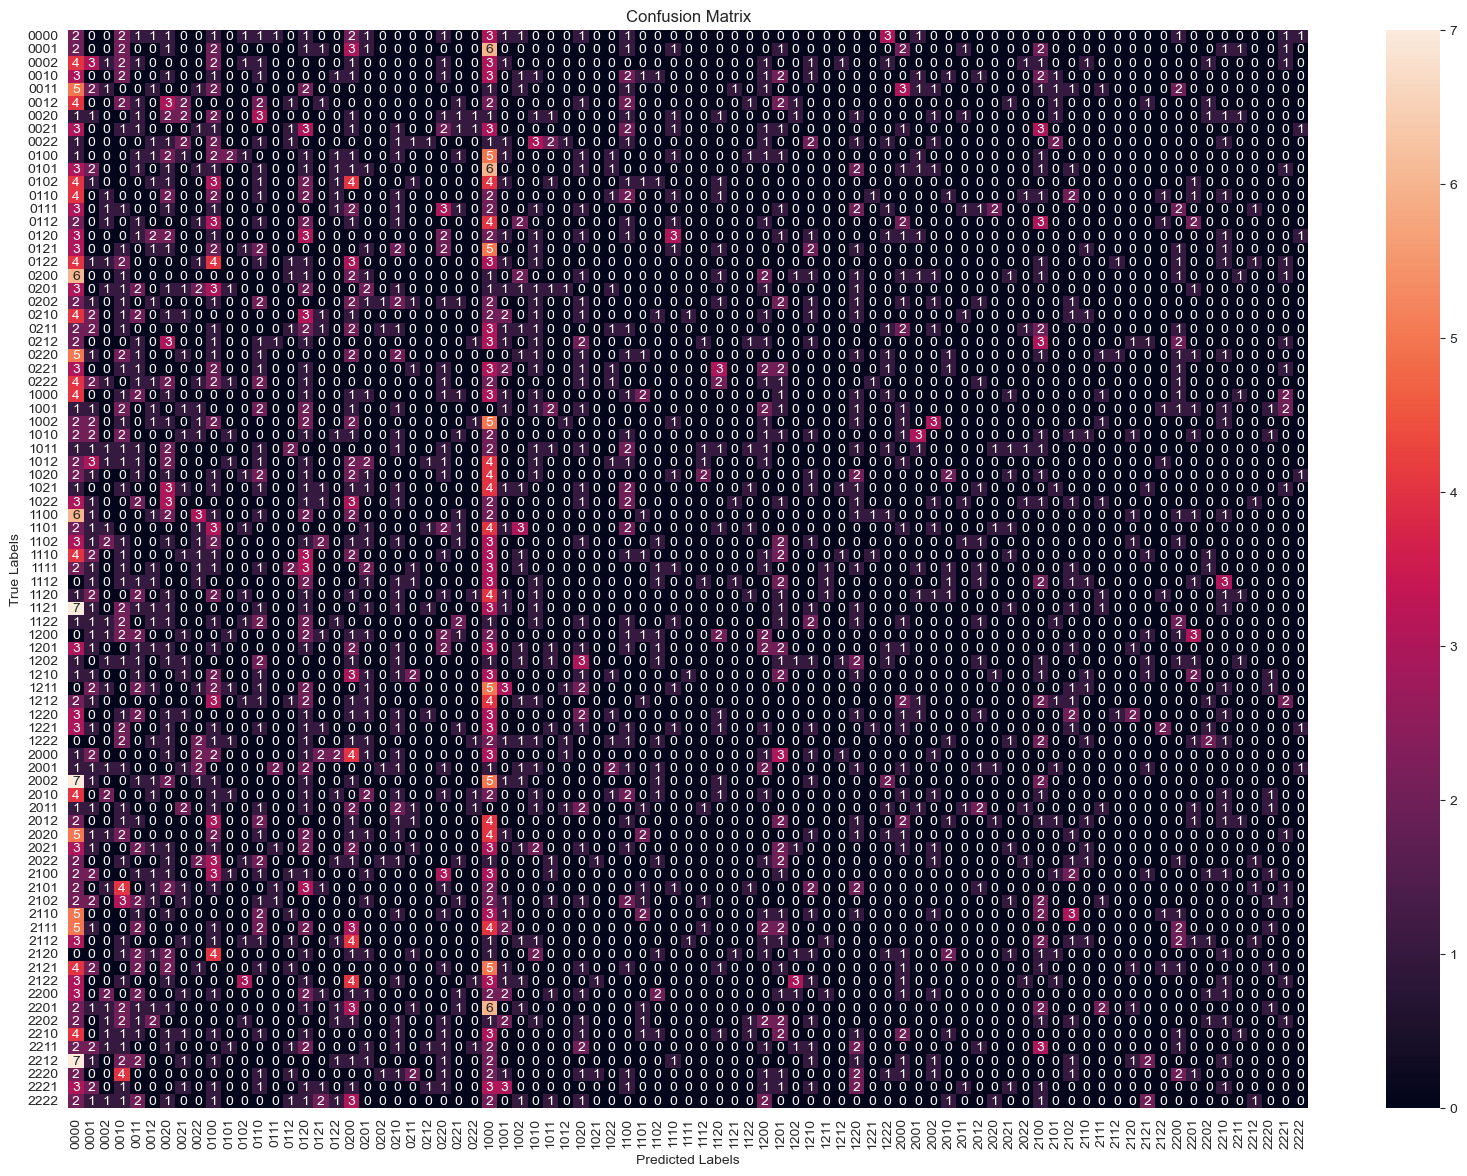

0.014814814814814815


In [74]:
model_3D.eval()  # Set the model to evaluation mode
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in train_loader_dots:
        inputs = batch[0].to(device)
        # print(torch.max(batch[1], 1)[1])
        outputs = model_3D(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)
print(predicted_labels)

# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_train_dots, 1)
print(true_class_labels)
# print(torch.max(y_test_dots, 1)[1])
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(20, 14))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

In [75]:
# Loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr=fine_tune_hyperparams['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=fine_tune_hyperparams['factor'],
                              patience=fine_tune_hyperparams['patience'])

# Mixed precision training setup
scaler = torch.amp.GradScaler('cuda')

# Fine-tuning loop
train_losses = []
test_losses = []

for epoch in trange(fine_tune_hyperparams['num_epochs'], desc="Fine-tuning Progress"):
    model.train()
    total_loss = 0

    for inputs, targets in train_loader_dots:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):  # Enable mixed precision
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        # Backpropagation with scaled gradients
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    # Compute average loss for the epoch
    avg_loss = total_loss / len(train_loader_dots)
    train_losses.append(avg_loss)

    # Step the LR scheduler
    scheduler.step(avg_loss)

    # Log the current learning rate
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1}/{fine_tune_hyperparams['num_epochs']}, Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")

    # Calculate and print test loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader_dots:
                inputs, targets = inputs.to(device), targets.to(device)
                with torch.amp.autocast('cuda'):  # Mixed precision for inference
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_loader_dots)
        test_losses.append(avg_test_loss)
        print(f"Test Loss after Epoch {epoch + 1}: {avg_test_loss:.4f}")

# Save the fine-tuned model
fine_tuned_model_path = "fine_tuned_classifier_4foil_3d.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'hyperparams': fine_tune_hyperparams,
    'stages': stages,
    'pooling_configs': pooling_configs,
    'desired_res': desired_res,
    'num_classes': num_classes
}, fine_tuned_model_path)

print(f"Fine-tuned model saved to {fine_tuned_model_path}")

Fine-tuning Progress:   1%|          | 1/100 [00:04<07:24,  4.49s/it]

Epoch 1/100, Loss: 5.4024, LR: 0.000001


Fine-tuning Progress:   2%|▏         | 2/100 [00:08<07:16,  4.46s/it]

Epoch 2/100, Loss: 4.0134, LR: 0.000001


Fine-tuning Progress:   3%|▎         | 3/100 [00:13<07:11,  4.45s/it]

Epoch 3/100, Loss: 3.4555, LR: 0.000001


Fine-tuning Progress:   4%|▍         | 4/100 [00:17<07:06,  4.44s/it]

Epoch 4/100, Loss: 3.1474, LR: 0.000001


Fine-tuning Progress:   5%|▌         | 5/100 [00:22<07:01,  4.44s/it]

Epoch 5/100, Loss: 2.9299, LR: 0.000001


Fine-tuning Progress:   6%|▌         | 6/100 [00:26<06:57,  4.44s/it]

Epoch 6/100, Loss: 2.7693, LR: 0.000001


Fine-tuning Progress:   7%|▋         | 7/100 [00:31<06:54,  4.45s/it]

Epoch 7/100, Loss: 2.6467, LR: 0.000001


Fine-tuning Progress:   8%|▊         | 8/100 [00:35<06:53,  4.49s/it]

Epoch 8/100, Loss: 2.5495, LR: 0.000001


Fine-tuning Progress:   9%|▉         | 9/100 [00:40<06:48,  4.49s/it]

Epoch 9/100, Loss: 2.4693, LR: 0.000001


Fine-tuning Progress:   9%|▉         | 9/100 [00:43<07:19,  4.83s/it]


KeyboardInterrupt: 

2430
2430


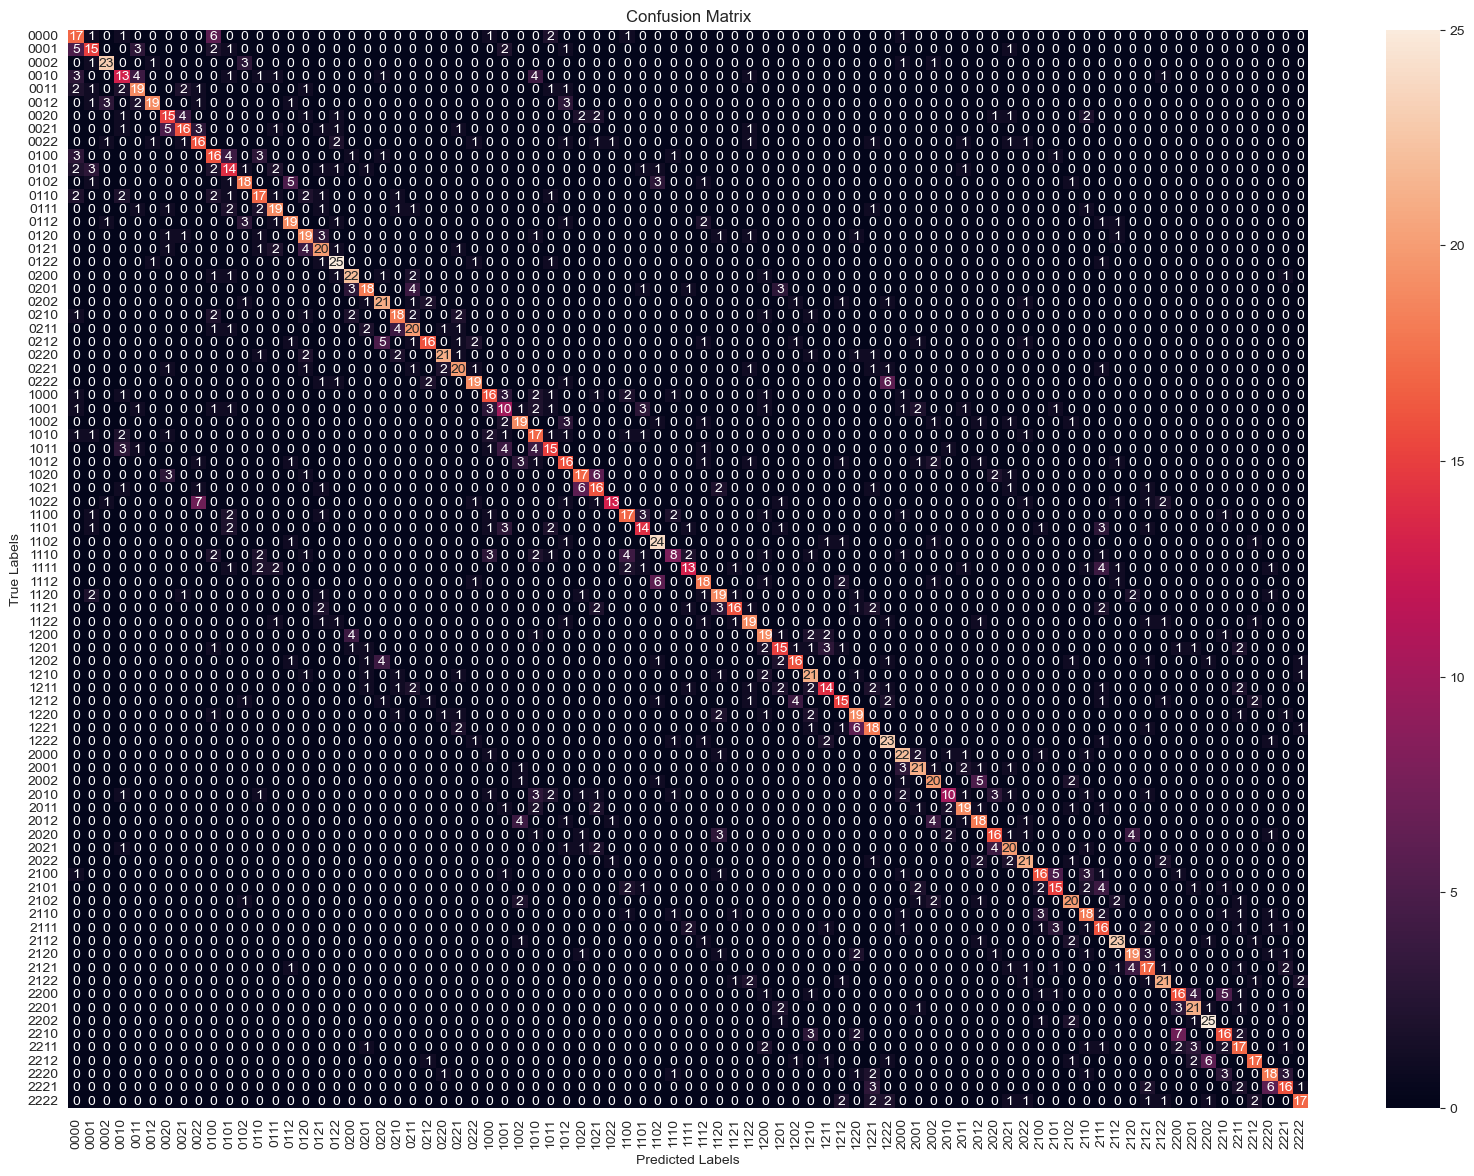

0.591358024691358


In [53]:
model.eval()  # Set the model to evaluation mode
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader_dots:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)
# print(predicted_labels)
print(len(predicted_labels))
# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_test_dots, 1)
print(len(true_class_labels))
# print(true_class_labels)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
plt.figure(figsize=(20, 14))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)

In [ ]:

foils = list(itertools.product(range(3), repeat=4))
foils = foils[:]
knots = [''.join([str(element) for element in foil]) for foil in foils]
knot_types = {
	knot: it for it, knot in enumerate(knots)
}

# folder = '../DATA/HOPFS_L270_5e-07_test_1s'
# folder = '../HOPFS_L270_5e-07_test_1s'
# List of folders to search for data
# folders = [
#     '../4foils_L270_0.15_50_64x64x64_v1',
#     '../4foils_L270_0.05_50_64x64x64_v1',
#     '../4foils_L270_0.25_50_64x64x64_v1'
# ]
folders = [
    '../DATA/4foils_L270_0.25_50_64x64x64_v2',
    '../DATA/4foils_L270_0.15_50_64x64x64_v2',
    '../DATA/4foils_L270_0.05_50_64x64x64_v2',

]

num_classes = len(knots)
X_list = []
Y_list = []
csv.field_size_limit(10000000)

# Flag to print shape once
flag_print_shape = True

# Loop through all folders and knots
for folder in folders:
	for knot in knots:
		filename = f'{folder}/data_{knot}.csv'
		try:
			with open(filename, 'r') as file:
				reader = csv.reader(file)
				for row in reader:
					# Deserialize the JSON string back to a list
					data_list = json.loads(row[0])
					data_array = np.array(data_list)

					# Extract points and dimensions
					points_list = data_array[2:]
					Nx, Ny, Nz = data_array[1]

					if flag_print_shape:
						print(f'Shape: {Nx}, {Ny}, {Nz}')
						flag_print_shape = False

					# Rescale if necessary
					if desired_res != (Nx, Ny, Nz):
						scale_x = desired_res[0] / Nx
						scale_y = desired_res[1] / Ny
						scale_z = desired_res[2] / Nz
						points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)

					# Initialize a 3D array and set points to 1
					dots_3d = np.zeros(desired_res, dtype=int)
					for x, y, z in points_list:
						try:
							dots_3d[x, y, z] = 1
						except IndexError:
							continue

					# Append to lists
					X_list.append(dots_3d)
					Y_list.append(knot_types[knot])

		except FileNotFoundError:
			print(f'File not found: {filename}')
		except json.JSONDecodeError:
			print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')

In [ ]:
X_np_sim = np.array(X_list)
y_np_sim = np.array(Y_list)
# print(X_np)
X_torch_dots_sim = torch.tensor(X_np_sim).reshape(-1,1, *desired_res).float()
y_torch_list_sim = torch.tensor(y_np_sim)
y_dots_sim = F.one_hot(y_torch_list_sim.long(), num_classes=num_classes).float()
print(X_torch_dots_sim.shape, y_dots_sim.shape)

test_dataset_dots_sim = TensorDataset(X_torch_dots_sim, y_dots_sim)
test_loader_dots_sim = DataLoader(test_dataset_dots_sim, batch_size=hyperparams['batch_size'])

In [ ]:
model.eval()  # Set the model to evaluation mode
predicted_labels = []
with torch.no_grad():  # Disable gradient calculation
    for batch in test_loader_dots_sim:
        inputs = batch[0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
# Convert the list to a numpy array
predicted_labels = np.array(predicted_labels)
# If you need the result as a tensor, convert back to tensor
predicted_labels = torch.tensor(predicted_labels)

# _, predicted_labels = torch.max(model(X_test.to(device)), 1)
_, true_class_labels = torch.max(y_dots_sim, 1)
predicted_labels_np = predicted_labels.cpu().numpy()
true_labels_np = true_class_labels.cpu().numpy()
cm = confusion_matrix(true_labels_np, predicted_labels_np)
np.savez("foils_dots_part_all.npz", cm=cm)
# np.savez("MSE_spec_part_all.npz", cm=cm)
# np.savez("MSE_dots_full_all.npz", cm=cm)
# np.savez("MSE_dots_part_all.npz", cm=cm)
plt.figure(figsize=(20, 14))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=knots, yticklabels=knots)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
Accuracy = (np.sum(predicted_labels_np == true_labels_np)) / len(predicted_labels_np)
print(Accuracy)